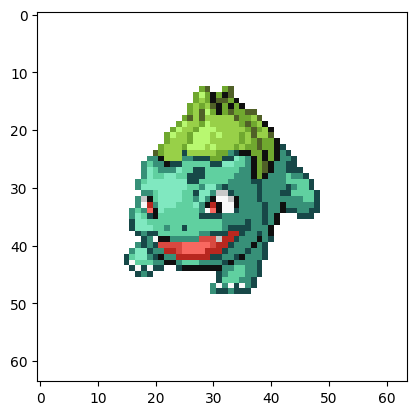

In [1]:
from PIL import Image
import torch
from torchvision import transforms
from torch import nn
import numpy as np

from matplotlib import pyplot as plt

torch.set_printoptions(sci_mode=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from load_dataset import load_dataset, plot_image
from tqdm import tqdm
from random import randint

pimages = load_dataset().to(device)
pimages.shape # [3, 386, 3, 64, 64]

plot_image(pimages[0, 0, :, :, :])

In [2]:
class PConv(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, bias=False, residual=False):
        super().__init__()
        self.residual = residual
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding='same', bias=bias),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
        )

    def forward(self, x):
        if self.residual:
            return self.conv(x) + x
        return self.conv(x)

class TConv(nn.Module):
    def __init__(self, in_c, out_c, bias=False):
        super().__init__()
        self.tconv = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1,
                               bias=bias),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
        )               
    
    def forward(self, x):
        return self.tconv(x)

class ImageTransformer(nn.Module):
    def __init__(self, in_c=3, out_c=16):
        super().__init__()
        self.emb = nn.Conv2d(in_c, out_c, kernel_size=1, bias=True)
        self.layer1 = nn.TransformerEncoderLayer(d_model=out_c, nhead=4, dim_feedforward=128, batch_first=True)

    def forward(self, x):
        shape = x.shape

        x = self.emb(x)

        x = x.flatten(2, 3).permute(0, 2, 1)
        x = self.layer1(x)
        x = x.permute(0, 2, 1).unflatten(2, shape[2:])

        return x

class PaletteDecoder(nn.Module):
    def __init__(self, features=64):
        super().__init__()

        self.feat0 = nn.Parameter(torch.randn(1, 1, features))
        self.linear = nn.Linear(features, 16 * 3)

        self.layer1 = nn.TransformerEncoderLayer(d_model=features, nhead=4, dim_feedforward=96, batch_first=True)
        self.layer = nn.TransformerEncoder(self.layer1, num_layers=2)
    
    def forward(self, x):
        # x: [batch, 64, 8, 8]
        
        x = x.flatten(2, 3)
        # x: [batch, 64, 8*8]

        x = x.permute(0, 2, 1)
        # x: [batch, 8*8, 64]

        x = torch.cat([self.feat0.expand(x.shape[0], -1, -1), x], dim=1)
        # x: [batch, 8*8 + 1, 64]

        x = self.layer(x)
        # x: [batch, 8*8 + 1, 64]
        
        x = x[:, 0, :]
        x = self.linear(x)
        # x: [batch, 16 * 3]

        x = x.unflatten(1, (16, 3))
        
        return torch.sigmoid(x) * 2 - 1

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = nn.Sequential(
            PConv(3, 16, bias=True, kernel_size=1),
            PConv(16, 16, residual=True),
            PConv(16, 16, residual=True),
        ) # ----> x1

        self.down2 = nn.Sequential(
            nn.MaxPool2d(2), # 32 x 32
            PConv(16, 32),
            PConv(32, 32, residual=True),
            PConv(32, 32, residual=True),
        ) # ----> x2

        self.it = nn.Sequential(
            nn.MaxPool2d(2), # 16 x 16
            ImageTransformer(32, 32),
        )

        self.decode_palette = PaletteDecoder(32)

        self.up1 = nn.Sequential(
            PConv(32, 32, residual=True),
            PConv(32, 32, residual=True),
            TConv(32, 32), # 32 x 32
        )

        self.up2 = nn.Sequential( # x2 ---->
            PConv(64, 32),
            PConv(32, 32, residual=True),
            TConv(32, 32), # 64 x 64
        )

        self.up3 = nn.Sequential( # x1 ---->
            PConv(48, 32),
            PConv(32, 32, residual=True),

            PConv(32, 16, bias=True, kernel_size=1),
            nn.Softmax(dim=2),
        )


    def forward(self, x):

        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.it(x2)

        palette = self.decode_palette(x3)
        
        x4 = self.up1(x3)
        x4 = torch.cat([x4, x2], dim=1)

        x5 = self.up2(x4)
        x5 = torch.cat([x5, x1], dim=1)

        x6 = self.up3(x5)

        return palette, x6

  0%|          | 0/50001 [00:00<?, ?it/s]

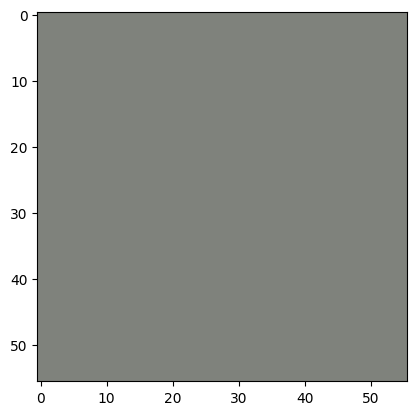

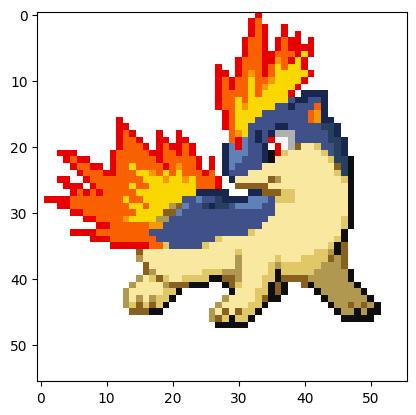

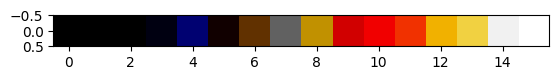

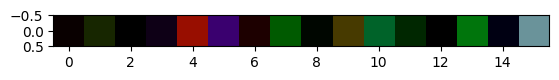

0.99903589:  10%|▉         | 4996/50001 [00:37<05:35, 134.00it/s]

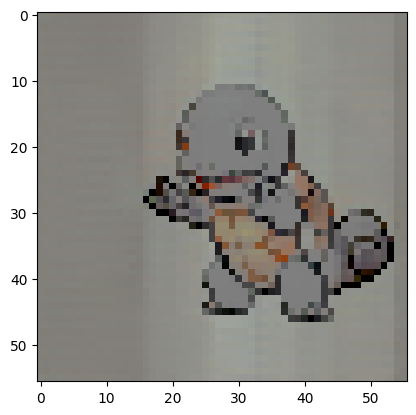

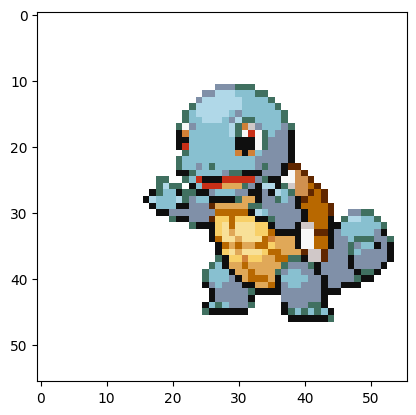

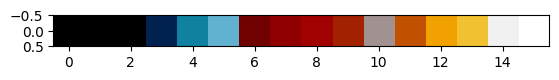

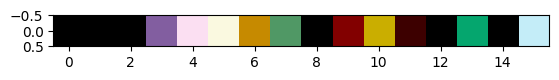

0.84565890:  20%|█▉        | 9988/50001 [01:15<05:12, 128.19it/s]

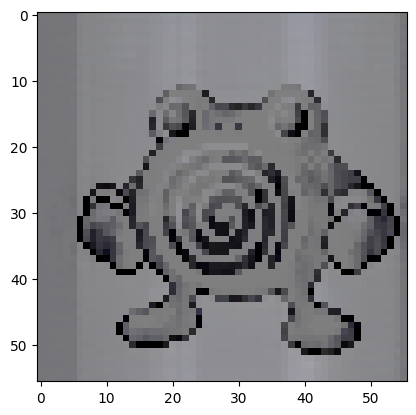

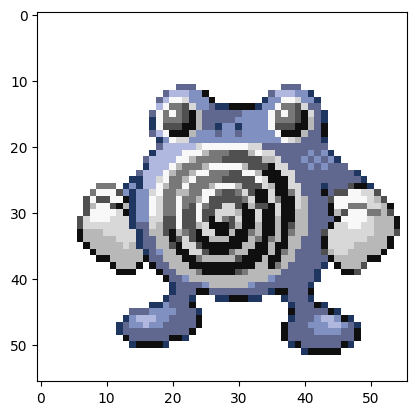

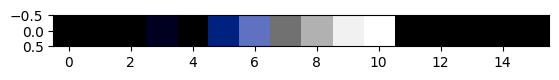

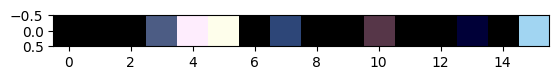

0.80893052:  21%|██▏       | 10703/50001 [01:20<04:56, 132.33it/s]


KeyboardInterrupt: 

In [4]:
bs = 8

L = nn.Sequential(
    nn.Linear(3, 256),
    nn.ReLU(),
).to(device)
torch.nn.init.normal_(L[0].bias, 0, 0.5)

model = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


#random crop
Crop = transforms.RandomCrop(56)

def get_pal(images): # images dim: [bs, 3, 64, 64]
    with torch.no_grad():
        colors = torch.ones(bs, 17, 3, device=device) * -1
        for i in range(images.shape[0]):
            col = images[i].flatten(1, 2).unique(dim=1).permute(1, 0)
            colors[i, :col.shape[0]] = col

    return colors[:, :16]

pbar = tqdm(range(50001), miniters=5)
def closure():
    optimizer.zero_grad()
    
    # Sample a batch of images
    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]

    # Shuffle the color channels
    color = torch.randperm(3)
    x0 = x0[:, color, :, :]
    x0 = Crop(x0)

    pal = get_pal(x0)

    palette, image = model(x0)
    image_rgb = ( image.flatten(2, 3).permute(0, 2, 1) @ palette ).permute(0, 2, 1).unflatten(2, (56, 56))

    loss = (x0 - image_rgb).pow(2).mean()
    loss += 0.5 * (L(palette).sum(dim=1) - L(pal).sum(dim=1)).abs().mean()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)

    loss.backward()
    return loss


 
model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 5000 == 0:
        with torch.no_grad():
            model.eval()
            
            source = randint(0, 2)
            batch = torch.randperm(385)[:1]
            x0 = pimages[source, batch]
            x0 = Crop(x0)

            pal = get_pal(x0)
            palette, image = model(x0)
            image_rgb = ( image.flatten(2, 3).permute(0, 2, 1) @ palette ).permute(0, 2, 1).unflatten(2, (56, 56))

            plot_image(image_rgb[0])
            plot_image(x0[0])

            plt.imshow(pal[0, None, ...].detach().clip(0,1).cpu())
            plt.show()

            plt.imshow(palette[0, None, ...].detach().clip(0,1).cpu())
            plt.show()

            model.train()